In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def preprocess(train_df, test_df):
    train_df = handle_columns(train_df)
    test_df = handle_columns(test_df)

    for col in ['Age', 'Weight', 'Height', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI']:
        train_df, test_df = handle_outliers(train_df, test_df, col)

    train_df = remove_outliers(train_df, 'Calories')

    return train_df, test_df

def handle_columns(df):
    df = df.set_index('id')
    df['female'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
    df['male'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
    df = df.drop(columns=['Sex'])
    df['Age'] = df['Age'].astype('float64')

    # construct new features
    df['BMI'] = df['Weight'] / ((df['Height']/100.0) ** 2)
    df['BSA'] = (df['Weight'] ** 0.425 * df['Height'] ** 0.725) * 0.007184
    df['FFM'] = 0.407*df['Weight'] + 0.267*df['Height'] - 19.2
    df['HRMax'] = 220.0 - df['Age']
    df['%HRMax'] = df['Heart_Rate'] / df['HRMax']
    df['HRR'] = df['HRMax'] - df['Heart_Rate']
    df['TRIMPlite'] = df['Duration'] * df['%HRMax']
    df['tempdiff'] = df['Body_Temp'] - 37.0
    df['thermal_load'] = df['tempdiff'] * df['Duration']
    df['keytel'] = df['Duration'] * (
        df['Weight']     * (0.0475 * df['male']  - 0.0302 * df['female'])
        + df['Heart_Rate'] * (0.151  * df['male']  + 0.107  * df['female'])
        - 13.17 * df['male']  - 4.88 * df['female']
    )


    target_col = 'Calories'
    categorical_cols = [col for col in df.select_dtypes(include=['category']).columns.to_list() if col != target_col]
    numerical_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns.to_list() if col != target_col]
    """
    for col1 in numerical_cols:
        if df[col1].dtype == 'float64':
            df[f'{col1}^2'] = df[col1] ** 2
            df[f'{col1}^3'] = df[col1] ** 3
            df[f'log1p({col1})'] = np.log1p(df[col1])
            for col2 in numerical_cols:
                if df[col2].dtype == 'float64' and col1 != col2:
                    df[f'{col1}+{col2}'] = df[col1] + df[col2]
                    df[f'{col1}-{col2}'] = df[col1] - df[col2]
                    df[f'{col1}*{col2}'] = df[col1] * df[col2]
                    df[f'{col1}/{col2}'] = df[col1] / df[col2]"""
    return df

def handle_outliers(train_df, test_df, column):
    q1 = train_df[column].quantile(0.25)
    q3 = train_df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    train_df = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]
    test_df[column] = test_df[column].clip(lower_bound, upper_bound)
    return train_df, test_df

def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train, test = preprocess(train, test)

target_col = 'Calories'
categorical_cols = [col for col in train.select_dtypes(include=['category']).columns.to_list() if col != target_col]
numerical_cols = [col for col in train.select_dtypes(include=['float64', 'int64']).columns.to_list() if col != target_col]

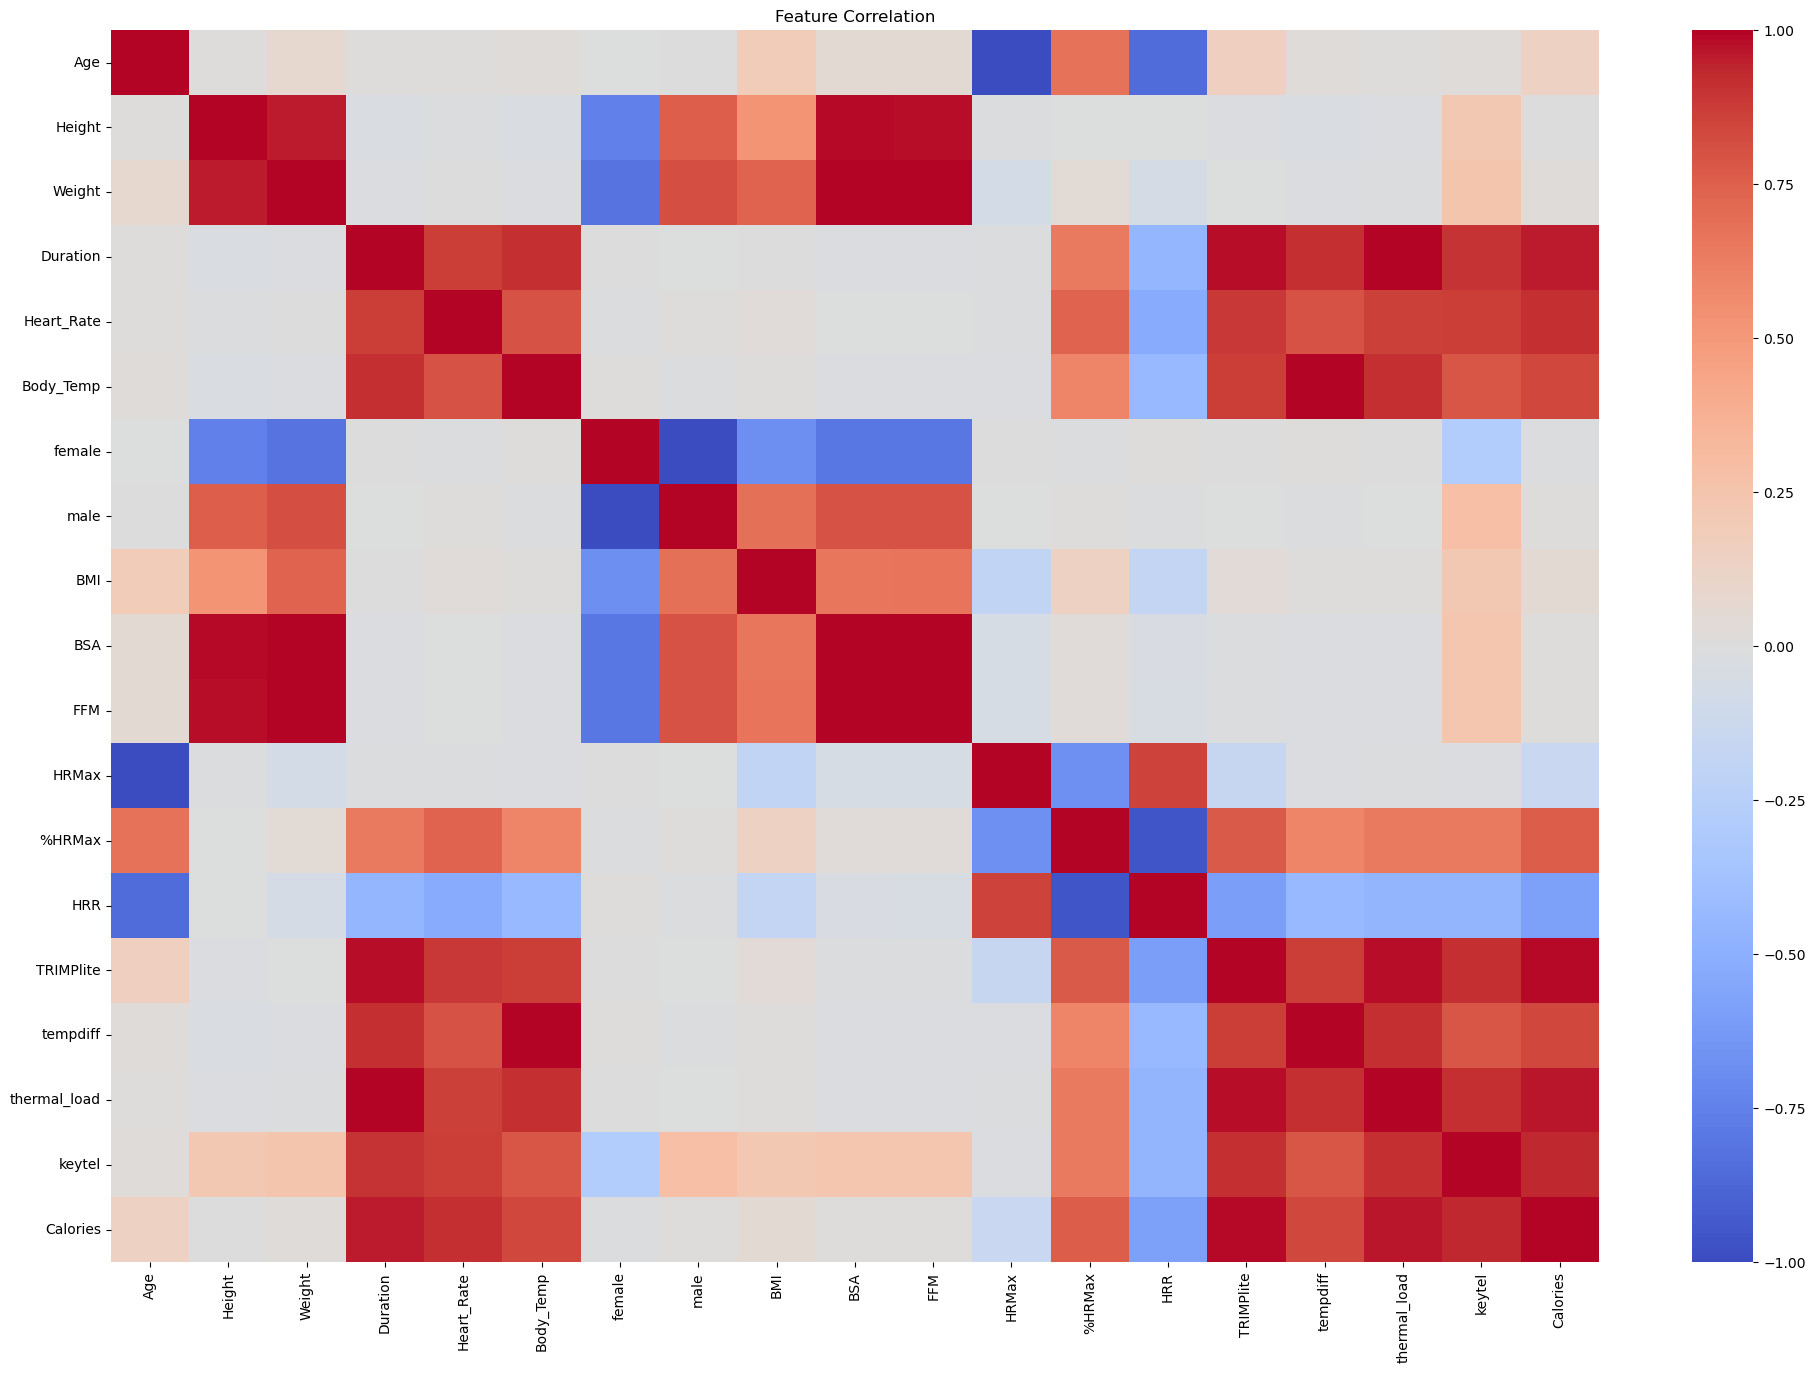

In [4]:
# feature correlation
plt.figure(figsize=(24, 16))
sns.heatmap(train[numerical_cols + [target_col]].corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()